In [22]:
import matplotlib.pyplot as plt
import math
from typing import List, Tuple, Union
from random import randint
import time
from tqdm.auto import tqdm

## Set up

In [2]:
class Point:
	def __init__(self, x, y):
		self.x = x
		self.y = y
	
	def compareX(self, p2):
		return (self.x - p2.x)

	def compareY(self, p2):
		return (self.y - p2.y)

	def dist(self, p2):
    		return math.sqrt((self.x - p2.x)*(self.x - p2.x) + (self.y - p2.y)*(self.y - p2.y))
	
	def __str__(self) -> str:
		return f"({self.x}, {self.y})"

## Divide and Conquer
**Resource:** https://www.geeksforgeeks.org/closest-pair-of-points-onlogn-implementation/

In [3]:
def smallest_dis(P: List[Point], n: int):
    min_so_far = float('inf')
    for i in range(n):
        for j in range(i+1, n):
            if P[i].dist(P[j]) < min_so_far:
                min_so_far = P[i].dist(P[j])
    return min_so_far

def strip_closest(strip: int, size: int, d: float) -> float:
    min_so_far: float = d
 
    for i in range(size):
        for j in range(i+1, size):
            if (strip[j].y - strip[i].y) < min_so_far:
                if strip[i].dist(strip[j]) < min_so_far:
                    min_so_far = strip[i].dist(strip[j])
    return min_so_far

def closest_util(px, py, n) -> float:
    if n <= 3:
        return smallest_dis(px, n)
 
    mid_idx: int = n // 2
    mid_point: Point = px[mid_idx]
 
 
    pyl: List[Point] = py[:mid_idx]
    pyr: List[Point] = py[mid_idx:]
 
    dl: float = closest_util(px, pyl, mid_idx)
    dr: float = closest_util(px[mid_idx:], pyr, n-mid_idx)
 
    distance: float = min(dl, dr)
 
    strip: List[Point] = [py[i] for i in range(n) if abs(py[i].x - mid_point.x) < distance]
    return strip_closest(strip, len(strip), distance)
 
def closest_divide_and_conquer(points: List[Point]):
    px = points
    py = points
    px.sort(key=lambda x:x.x)
    py.sort(key=lambda x:x.y)
    return closest_util(px, py, len(points))


## Grid Algorithm

In [24]:
class Cell:
	def __init__(self):
		self.points = []
	
	def add_point(self, p):
		self.points.append(p)
	
class Grid: 
	def __init__(self, num_x: int, num_y: int, threshold: float) -> None:
		self.max_x: int = math.ceil(num_x / threshold)
		self.max_y: int = math.ceil(num_y / threshold)
		self.threshold: float = threshold
		self.cells: List[Cell] = [Cell() for i in range(self.max_x * self.max_y)]
	
	def get_nbr_cell(self, x: int, y: int) -> Cell:
		if (x >= self.max_x) or (y >= self.max_y) or (x < 0) or (y < 0):
			return None
		return self.cells[(self.max_x * y) + x]
	
	def add_point_to_cell(self, point: Point) -> None:
		row_cell = math.floor(point.x / self.threshold)
		col_cell = math.floor(point.y / self.threshold)
		# print(row_cell, col_cell)
		self.cells[(self.max_x * col_cell) + row_cell].add_point(point)

def check_closest_point(grid: Grid, point: Point, threshold: int) -> Tuple[Point, float]:
	row_cell = math.floor(point.x / threshold)
	col_cell = math.floor(point.y / threshold)
	directions: List[Tuple[int, int]] = [
		(0,0),
		(0,1), # top
		(0,-1), # bottom
		(1,0), # right
		(-1,0), # left
		(-1,1), # top left
		(-1,-1), # bottom left
		(1,-1), # bottom right
		(1,1), # top right
	]
	min_dis = float('inf')
	closest_point = None
	for (direction_x, direction_y) in directions:
		current_cell: Cell = grid.get_nbr_cell(row_cell + direction_x, col_cell + direction_y)
		if (current_cell != None):
			for nbr_point in current_cell.points:
				if (nbr_point.x != point.x) and (nbr_point.y != point.y):
					distance = point.dist(nbr_point)
					if (distance < min_dis):
						min_dis = distance
						closest_point = nbr_point
	return closest_point, min_dis
				
	

def closest_pair_grid(points: List[Point], max_x: int, max_y: int) -> float:
	if len(points) <= 1:
		return float('-inf')
	elif len(points) == 2:
		return points[0].dist(points[2])
	r = points[0].dist(points[1])
	grid = Grid(max_x, max_y, r)
	grid.add_point_to_cell(points[0])
	grid.add_point_to_cell(points[1])
	for point_idx in range(2, len(points)):
		current_point = points[point_idx]
		closest_point, distance = check_closest_point(grid, current_point, r)
		if (distance < r):
			r = distance
			grid = Grid(max_x, max_y, r)
			grid.add_point_to_cell(current_point)
			grid.add_point_to_cell(closest_point)
		else:
			grid.add_point_to_cell(current_point)
	return r



### Benchmark

In [46]:
def random_points(n: int) -> Tuple[List[Point], Point]:
    points: List[Point] = []
    max_x: int = float('-inf')
    max_y: int = float('-inf')
    for _ in range(n):
        x: int = randint(0, 499)
        y: int = randint(0, 499)
        if (x > max_x): 
            max_x = x
        if (y > max_y):
            max_y = y
        points.append(Point(x, y))
    return points, Point(x=max_x, y=max_y)
    
points, max_point = random_points(100)
print("Divide and conquer: ", closest_divide_and_conquer(points))
print("Grid: ", closest_pair_grid(points, max_point.x, max_point.y))


Divide and conquer:  4.242640687119285
Grid:  4.242640687119285


In [47]:

# Divide and conquer
def benchmark_divide_and_conquer(rounds: int, n: int) -> List[float]:
    result = []
    for point_amount in tqdm(range(3, n)):
        points, _ = random_points(point_amount)
        total = 0
        for _ in range(rounds):
            start_time = time.perf_counter()
            closest_divide_and_conquer(points)
            end_time = time.perf_counter()
            total += end_time - start_time
        result.append((total / rounds))
    return result


def benchmark_grid(rounds: int, n: int) -> List[float]:
    result = []
    for point_amount in tqdm(range(3, n)):
        points, max_point = random_points(point_amount)
        total = 0
        for _ in range(rounds):
            start_time = time.perf_counter()
            closest_pair_grid(points, max_point.x, max_point.y)
            end_time = time.perf_counter()
            total += end_time - start_time
        result.append((total / rounds))
    return result

  0%|          | 0/197 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


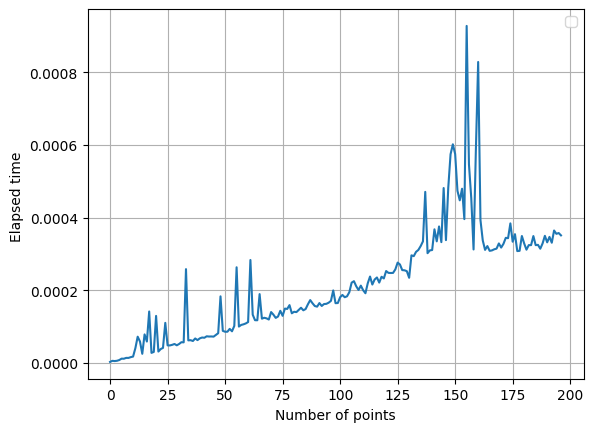

In [72]:
dc_result = benchmark_divide_and_conquer(10,200)
plt.plot([i for i in range(len(dc_result))], dc_result)
# plt.plot(resizable_array_df['operation_amount'], resizable_array_df['cpu_count'], label="Resizable array")
plt.xlabel('Number of points')
plt.ylabel('Elapsed time ')
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/197 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


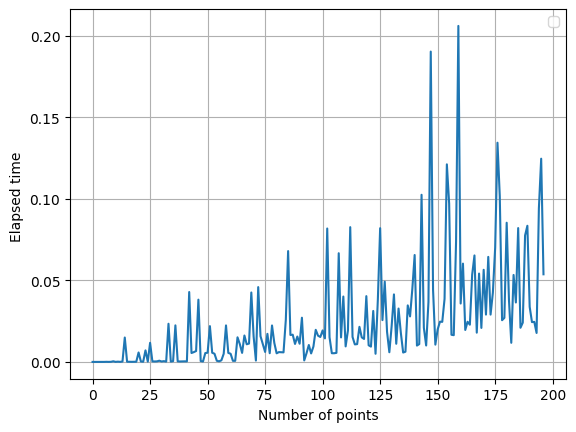

In [74]:
g_result = benchmark_grid(10,200)
plt.plot([i for i in range(len(g_result))], g_result)
plt.xlabel('Number of points')
plt.ylabel('Elapsed time ')
plt.legend()
plt.grid()
plt.show()

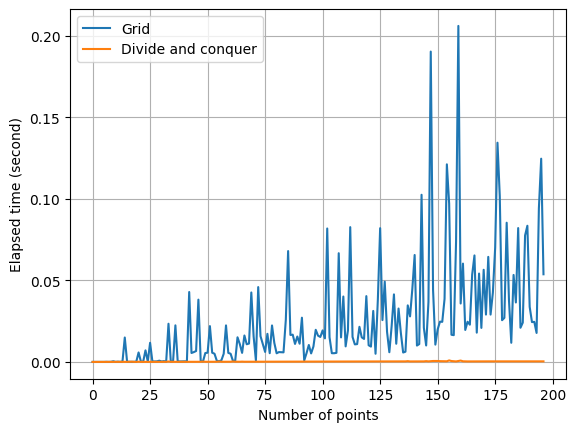

In [75]:
plt.plot([i for i in range(len(g_result))], g_result, label="Grid")
plt.plot([i for i in range(len(dc_result))], dc_result, label="Divide and conquer")
plt.xlabel('Number of points')
plt.ylabel('Elapsed time (second)')
plt.legend()
plt.grid()
plt.show()